In [1]:
import os
import io
import platform
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
import random
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
from PIL import ImageOps

In [2]:
desired_width = 224
transform=transforms.ToTensor()
def process_img(image):
    desired_length = int(desired_width * (image.size[0]/image.size[1]))
    new=image.resize((desired_width, desired_width))
    back = Image.new("L", (224, 224))  
    back.paste(new)
    img=transform(back)
    new.close()
    back.close()
    return img

In [3]:
FILE_PATH="./chest_xray/"
def load_data(dataset):
    path=FILE_PATH+dataset+"/"
    data=[]
    for file in os.listdir(path+"PNEUMONIA/"):
        if not(file.startswith('.')):
            img=Image.open(path+"PNEUMONIA/"+file)
            temp=[]
            temp.append(process_img(img.convert("L")))
            temp.append(torch.FloatTensor([1]))
            data.append(temp)
            img.close()
    for file in os.listdir(path+"NORMAL/"):
        if not(file.startswith('.')):
            img=Image.open(path+"NORMAL/"+file)
            temp=[]
            temp.append(process_img(img.convert("L")))
            temp.append(torch.FloatTensor([0]))
            data.append(temp)
            img.close()
    return data

In [4]:
train_set=load_data("train")
test_set=load_data("test")
val_set=load_data("val")

In [5]:
train_set[0][0]

tensor([[[ 0.8078,  0.8039,  0.8078,  ...,  0.7686,  0.8039,  0.8353],
         [ 0.8039,  0.8000,  0.8039,  ...,  0.7608,  0.8314,  0.8157],
         [ 0.8000,  0.8000,  0.7961,  ...,  0.7686,  0.8157,  0.8314],
         ...,
         [ 0.0706,  0.0549,  0.0471,  ...,  0.1843,  0.1922,  0.2000],
         [ 0.0549,  0.0549,  0.0471,  ...,  0.1804,  0.1882,  0.1882],
         [ 0.0549,  0.0549,  0.0471,  ...,  0.1765,  0.1804,  0.1804]]])

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cl1=nn.Conv2d(1,12,kernel_size=3)
        self.mp1=nn.MaxPool2d(2)
        self.cl2=nn.Conv2d(12,3,kernel_size=3)
        self.mp2=nn.MaxPool2d(2)
        self.fcl=nn.Linear(8748,1)
        
    def forward(self,x):
        # x dim: b x 800 x 600 x 3 -> b x 1 x 100 x 100
        out=F.relu(self.cl1(x)) # b x 18 x whatever x whatever
        out=self.mp1(out)
        out=F.relu(self.cl2(out))
        out=self.mp2(out)
        
        # at this point, we should have a tensor that's b x inchannels x 1 x 1
        out=out.view(out.size(0),-1)
#         print(out.shape)
        out=F.sigmoid(self.fcl(out))
        return out

In [84]:
model=CNN()
model.eval()
optimizer=optim.Adam(model.parameters(),lr=0.001,weight_decay=0.001)
criterion=nn.BCELoss()

In [85]:
def train(epoch,model,train_loader,optimizer):
    model.train()
    
    total_loss=0
    correct=0
    
    for i, (image,label) in enumerate(train_loader):
        
        #print(i)
        optimizer.zero_grad()
        
#         print(label.shape)
       
        
        prediction=model(image)
        
        loss=criterion(prediction,label)
        
        loss.backward()
        
        optimizer.step()
        
        total_loss+=loss
        
        pred_classes=prediction.data.max(1,keepdim=True)[1]
#         print(type(pred_classes))
        
        correct+=pred_classes.eq(label.long().data.view_as(pred_classes)).sum().double()
        
    mean_loss=total_loss/len(train_loader.dataset)
    acc=correct/len(train_loader.dataset)
    
    print('Train Epoch: {}   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
        epoch, mean_loss, correct, len(train_loader.dataset),
        100. * acc))

    return mean_loss, acc

In [86]:
def eval(model,test_loader):
    model.eval()
    
    total_loss=0
    correct=0
    
    for i, (image,label) in enumerate(test_loader):
        
        optimizer.zero_grad()
        
        prediction=model(image)
        
        loss=criterion(prediction,torch.FloatTensor(label))
        
        loss.backward()
        
        optimizer.step()
        
        total_loss+=loss
        
        pred_classes=prediction.data.max(1,keepdim=True)[1]
        
#         print(type(pred_classes))
        
        correct+=pred_classes.eq(label.long().data.view_as(pred_classes)).sum().double()
        
    mean_loss=total_loss/len(test_loader.dataset)
    
    acc=correct/len(test_loader.dataset)
    
    print('Eval:   Avg_Loss: {:.5f}   Acc: {}/{} ({:.3f}%)'.format(
         mean_loss, correct, len(test_loader.dataset),
        100. * acc))

    return mean_loss, acc

In [87]:
def save_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'chestXRay_{}.pt'.format(epoch)
    
    # load the model parameters 
    torch.save(model.state_dict(), filename)
    
    
    return model

def load_model(epoch, model, path='./'):
    
    # file name and path 
    filename = path + 'chestXRay_{}.pt'.format(epoch)
    
    # load the model parameters 
    model.load_state_dict(torch.load(filename))
    
    
    return model

In [88]:
BATCH_SIZE=8
train_loader=data.DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)
valid_loader=data.DataLoader(val_set,batch_size=BATCH_SIZE,shuffle=True)
test_loader=data.DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)

In [89]:
train_loader

In [90]:
num_epoch=10
checkpoint_freq=5
path="./"

train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

# traininng 
for epoch in range(1, num_epoch + 1):
    
    # train() function (see above)
    train_loss, train_acc = train(epoch, model, train_loader, optimizer)
    
    # eval() functionn (see above)
    test_loss, test_acc = eval(model, test_loader)    
    
    # append lists for plotting and printing 
    train_losses.append(train_loss)    
    test_losses.append(test_loss)
    
    train_accuracies.append(train_acc)    
    test_accuracies.append(test_acc)
    
    # Checkpoint
    if epoch % checkpoint_freq ==0:
        save_model(epoch, model, path)

# Last checkpoint
save_model(num_epoch, model, path)
    
print("\n\n\nOptimization ended.\n") 

Train Epoch: 1   Avg_Loss: 0.02504   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.03758   Acc: 234.0/624 (37.500%)
Train Epoch: 2   Avg_Loss: 0.01406   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.04600   Acc: 234.0/624 (37.500%)
Train Epoch: 3   Avg_Loss: 0.01197   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.03458   Acc: 234.0/624 (37.500%)
Train Epoch: 4   Avg_Loss: 0.01089   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.03452   Acc: 234.0/624 (37.500%)
Train Epoch: 5   Avg_Loss: 0.01059   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.03798   Acc: 234.0/624 (37.500%)
Train Epoch: 6   Avg_Loss: 0.00978   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.03662   Acc: 234.0/624 (37.500%)
Train Epoch: 7   Avg_Loss: 0.00876   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.03529   Acc: 234.0/624 (37.500%)
Train Epoch: 8   Avg_Loss: 0.00756   Acc: 1331.0/5206 (25.567%)
Eval:   Avg_Loss: 0.03181   Acc: 234.0/624 (37.500%)
Train Epoch: 9   Avg_Loss: 0.00745   Acc: 1331.0/5206 (25.567%)


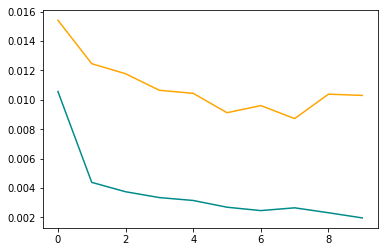

In [63]:
import matplotlib.pyplot as plt
plt.plot(train_losses,color='darkcyan')
plt.plot(test_losses,color='orange')
plt.show()

In [71]:
cnn=CNN()
cnn=load_model(10,cnn)

In [72]:
cnn

CNN(
  (cl1): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cl2): Conv2d(12, 3, kernel_size=(3, 3), stride=(1, 1))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fcl): Linear(in_features=8748, out_features=1, bias=True)
)

In [77]:
import matplotlib.pyplot as plt
losses=[]
total_loss=0
criterion=nn.MSELoss()
for i,(image,label) in enumerate (val_set):
#     print(image.shape)
    prediction=cnn(image.unsqueeze(0))
    print(prediction.shape)
    loss=criterion(prediction,label.unsqueeze(0))
    losses.append(loss)
    total_loss+=loss
avg_loss=total_loss/len(val_set)
print(avg_loss)

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])
tensor(1.00000e-02 *
       7.7142)


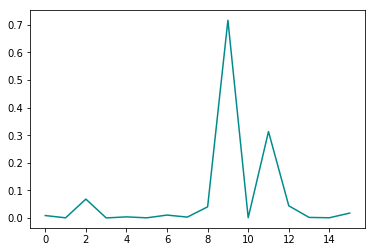

In [78]:
plt.plot(losses,color='darkcyan')
plt.show()